# 30 · Flujo óptico denso con Lucas–Kanade

## Flujo óptico disperso y denso

En la formulación clásica de Lucas–Kanade se estima el vector de flujo $\mathbf{w} = (u,v)^\top$ en una vecindad $\Omega$ alrededor de un punto dado, resolviendo el sistema en mínimos cuadrados

$I_x(x_i,y_i) u + I_y(x_i,y_i) v + I_t(x_i,y_i) = 0, \quad (x_i,y_i) \in \Omega$

En forma matricial, con

$A = \begin{bmatrix} I_x(x_1,y_1) & I_y(x_1,y_1) \\ \vdots & \vdots \\ I_x(x_n,y_n) & I_y(x_n,y_n) \end{bmatrix}, \quad \mathbf{w} = \begin{bmatrix} u \\ v \end{bmatrix}, \quad \mathbf{b} = -\begin{bmatrix} I_t(x_1,y_1) \\ \vdots \\ I_t(x_n,y_n) \end{bmatrix}$

la solución de mínimos cuadrados es

$\mathbf{w} = (A^\top A)^{-1} A^\top \mathbf{b}$

Cuando el cálculo se realiza solo en un conjunto de puntos de interés (por ejemplo esquinas) se obtiene un flujo óptico **disperso**. Si en lugar de ello se selecciona una malla de puntos sobre toda la imagen, se aproxima un flujo óptico **denso** mediante el mismo esquema local de Lucas–Kanade.

## Aproximación densa mediante malla regular de puntos

Sea una imagen de tamaño $H \times W$. Se define una malla regular de puntos

$\mathcal{G} = \{(x_j,y_k)\}$

espaciados cada $s$ píxeles en ambas direcciones. Para cada punto de la malla se aplica el algoritmo piramidal de Lucas–Kanade entre dos cuadros consecutivos de un video, obteniendo un vector de desplazamiento $(u,v)$ por punto. La malla regular aproxima así un campo de flujo denso, pero evaluado sólo en un subconjunto estructurado de píxeles.

Imports y ruta del video.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

VIDEO_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\coches.mp4"

Lectura de dos frames consecutivos y conversión a escala de grises.

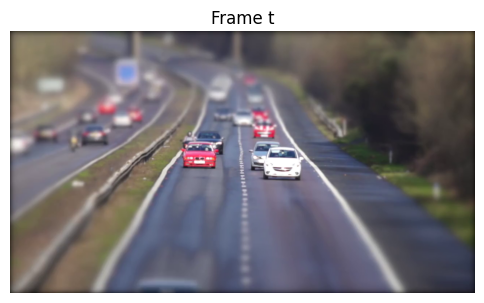

In [2]:
cap = cv2.VideoCapture(VIDEO_PATH)
ret1, frame1 = cap.read()
ret2, frame2 = cap.read()
if not ret1 or not ret2:
    cap.release()
    raise RuntimeError("No se pudieron leer dos frames consecutivos del video.")

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

rgb1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

cap.release()

plt.figure(figsize=(6,5))
plt.imshow(rgb1)
plt.title("Frame t")
plt.axis("off")
plt.show()

Definición de una malla regular de puntos sobre la imagen para aproximar un flujo denso.

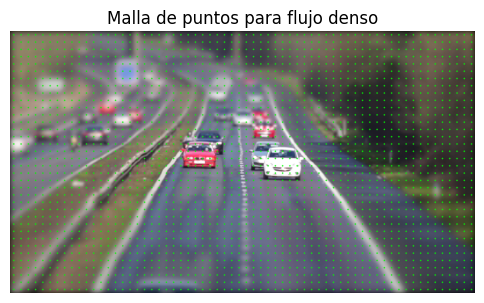

In [3]:
h, w = gray1.shape
step = 20  # separación entre puntos de la malla

ys, xs = np.mgrid[step//2:h:step, step//2:w:step]
grid_points = np.vstack((xs.ravel(), ys.ravel())).T.astype(np.float32)

p0 = grid_points.reshape(-1, 1, 2)

plt.figure(figsize=(6,5))
vis_grid = rgb1.copy()
for x, y in grid_points:
    cv2.circle(vis_grid, (int(x), int(y)), 2, (0,255,0), -1)
plt.imshow(vis_grid)
plt.title("Malla de puntos para flujo denso")
plt.axis("off")
plt.show()

Cálculo del flujo óptico en los puntos de la malla mediante Lucas–Kanade piramidal.

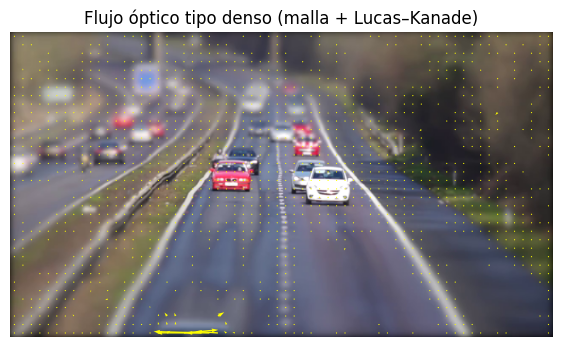

In [4]:
lk_params = dict(winSize=(21,21),
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)
if p1 is None:
    raise RuntimeError("No se pudo calcular el flujo óptico con Lucas–Kanade.")

st = st.reshape(-1)
good_new = p1[st == 1]
good_old = p0[st == 1]

if good_new.shape[0] == 0:
    raise RuntimeError("No hay puntos válidos después del seguimiento.")

good_new = good_new.reshape(-1, 2)
good_old = good_old.reshape(-1, 2)

u = good_new[:,0] - good_old[:,0]
v = good_new[:,1] - good_old[:,1]

plt.figure(figsize=(7,6))
plt.imshow(rgb1)
plt.quiver(good_old[:,0], good_old[:,1], u, -v, color="yellow", angles="xy", scale_units="xy", scale=1)
plt.title("Flujo óptico tipo denso (malla + Lucas–Kanade)")
plt.axis("off")
plt.show()